In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from datetime import datetime
import os
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Loading data

In [2]:
clicks = pd.read_pickle('C:/Users/Soyann/Code/Notebooks/OpenClassrooms/OC-P9-Recommendation mobile app/Data/clicks.pickle')
articles_metadata_df = pd.read_csv('C:/Users/Soyann/Code/Notebooks/OpenClassrooms/OC-P9-Recommendation mobile app/Data/articles_metadata.csv')
articles_embedding = pd.read_pickle('C:/Users/Soyann/Code/Notebooks/OpenClassrooms/OC-P9-Recommendation mobile app/Data/articles_embeddings.pickle')

# EDA

## Distribution during the day/the week

In [3]:
clicks.groupby(by=['click_day_of_week']).median()

,session_size,hour_id,article_id,category_id,created_at_ts,publisher_id,words_count,click_hour_of_day
click_day_of_week,,,,,,,,
0,3.0,200.0,166322.0,289.0,1.507481e+12,0.0,202.0,16.0
1,3.0,212.0,207024.0,331.0,1.507496e+12,0.0,199.0,14.0
2,3.0,236.0,233717.0,375.0,1.507619e+12,0.0,199.0,16.0
3,2.0,112.0,184184.0,301.0,1.507205e+12,0.0,199.0,16.0
4,3.0,138.0,166262.0,289.0,1.507303e+12,0.0,197.0,15.0
5,3.0,158.0,181582.0,301.0,1.507363e+12,0.0,205.0,13.0
6,2.0,178.0,202355.0,327.0,1.507408e+12,0.0,197.0,16.0


Text(0.5, 1.0, 'Number of users per day of week')

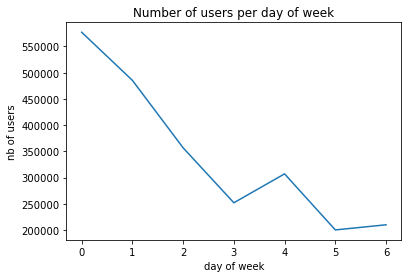

In [11]:
plt.plot(clicks.groupby(by=['click_day_of_week']).count().index,clicks.groupby(by=['click_day_of_week']).count().user_id)
plt.xlabel('day of week')
plt.ylabel('nb of users')
plt.title('Number of users per day of week')

Text(0.5, 1.0, 'Number of users per hour of day')

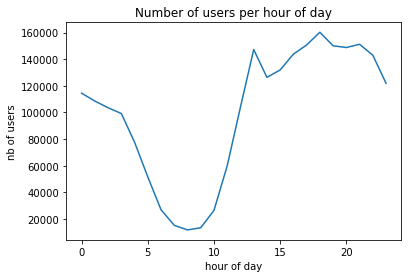

In [15]:
plt.plot(clicks.groupby(by=['click_hour_of_day']).count().index,clicks.groupby(by=['click_hour_of_day']).count().user_id)
plt.xlabel('hour of day')
plt.ylabel('nb of users')
plt.title('Number of users per hour of day')

Text(0.5, 1.0, 'Avg session size day of week')

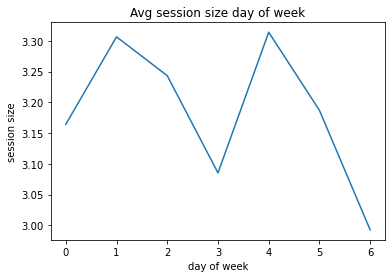

In [13]:
plt.plot(clicks.groupby(by=['click_day_of_week']).mean().index,clicks.groupby(by=['click_day_of_week']).mean().session_size)
plt.xlabel('day of week')
plt.ylabel('session size')
plt.title('Avg session size day of week')

Text(0.5, 1.0, 'Avg session size per hour of day')

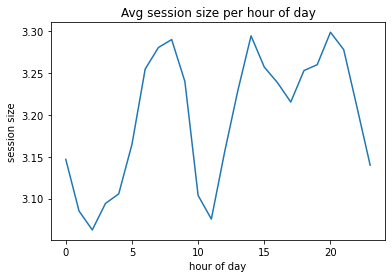

In [12]:
plt.plot(clicks.groupby(by=['click_hour_of_day']).mean().index,clicks.groupby(by=['click_hour_of_day']).mean().session_size)
plt.xlabel('hour of day')
plt.ylabel('session size')
plt.title('Avg session size per hour of day')

In [16]:
clicks.groupby(by=['user_id']).count().sort_values(by='session_id',ascending=False).describe()

,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,hour_id,click_datetime,article_id,category_id,created_at_ts,publisher_id,words_count,click_day_of_week,click_hour_of_day
count,314879.000000,314879.000000,314879.000000,314879.000000,314879.000000,314879.000000,314879.000000,314879.000000,314879.000000,314879.000000,314879.000000,314879.000000,314879.000000,314879.000000,314879.000000,314879.000000,314879.000000,314879.000000,314879.000000,314879.000000
mean,7.583033,7.583033,7.583033,7.583033,7.583033,7.583033,7.583033,7.583033,7.583033,7.583033,7.583033,7.583033,7.583033,7.583033,7.583033,7.583033,7.583033,7.583033,7.583033,7.583033
std,7.947930,7.947930,7.947930,7.947930,7.947930,7.947930,7.947930,7.947930,7.947930,7.947930,7.947930,7.947930,7.947930,7.947930,7.947930,7.947930,7.947930,7.947930,7.947930,7.947930
min,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
75%,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
max,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000


## Removing high frequency user who cannot be humans

We can resonnably consider that mor than 3 times a day on average cannot be considered as a human behavior, it is obvisously not a "regular" user.

In [17]:
clicks.groupby(by=['user_id']).count()

,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,hour_id,click_datetime,article_id,category_id,created_at_ts,publisher_id,words_count,click_day_of_week,click_hour_of_day
user_id,,,,,,,,,,,,,,,,,,,,
0,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
1,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
3,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
4,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322892,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
322893,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
322894,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [18]:
cliks_per_user_count=clicks.groupby(by=['user_id']).count()

In [19]:
outliers_ID=cliks_per_user_count[cliks_per_user_count['session_id']>45].index

In [20]:
outliers_ID

Int64Index([], dtype='int64', name='user_id')

In [107]:
clicks=clicks[~clicks.user_id.isin(outliers_ID)]

In [112]:
clicks

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,...,click_referrer_type,hour_id,click_datetime,article_id,category_id,created_at_ts,publisher_id,words_count,click_day_of_week,click_hour_of_day
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,...,2,0,2017-10-01 05:00:28,157541,281,1506800518000,0,280,6,5
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,...,2,0,2017-10-01 05:00:58,68866,136,1506816482000,0,226,6,5
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,...,2,0,2017-10-01 05:03:37,235840,375,1506807839000,0,159,6,5
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,...,2,0,2017-10-01 05:04:07,96663,209,1506788025000,0,206,6,5
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,...,2,0,2017-10-01 05:04:50,119592,247,1506784316000,0,239,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988174,34979,1508211369104327,1508211369000,7,157478,1508211974116,4,3,2,1,...,1,384,2017-10-17 05:46:14,157478,281,1508126462000,0,259,1,5
2988177,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,...,2,384,2017-10-17 05:41:12,30760,26,1508185091000,0,162,1,5
2988178,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,...,2,384,2017-10-17 05:41:42,157507,281,1508236945000,0,370,1,5
2988179,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,...,2,384,2017-10-17 05:38:33,234481,375,1508181572000,0,212,1,5


# Evaluation

We want to be able to evaluate the recommendation. We will then take out of the train dataset the last article seen by 500 users (even if it is the only one). This will be our test dataset. Then we'll implement a tester function that looks into the top 5 recommendation made by the recommender system for the user and count the number of good hits between test dataset and recommendation

## Split train / test

get the index of the records corresponding to last articles of each of the test users

In [3]:
users=clicks['user_id'].unique()
idx=[]
for user in users[0:500]:
    idx.append(clicks[clicks['user_id']==user].sort_values('click_timestamp',ascending=False).head(1).index[0])
    print(user)
clicks_train=clicks.drop(index=idx)
clicks_test=clicks.loc[idx]

0
1
2
3
4
6
7
9
12
13
14
15
18
19
20
21
25
26
27
28
29
30
31
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
49
52
53
54
56
57
58
59
60
61
62
63
65
66
67
68
69
70
71
72
73
74
75
76
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
118
121
122
123
124
125
126
128
129
130
131
132
133
134
135
136
137
138
139
141
142
145
146
147
148
150
151
155
156
158
159
160
161
162
163
164
165
166
167
168
170
171
172
173
174
175
176
177
178
179
180
181
182
185
186
187
188
190
192
193
194
195
196
197
198
199
200
202
204
205
206
207
208
209
211
213
214
215
216
218
219
220
222
223
224
226
227
228
229
230
231
232
233
234
235
236
239
240
241
242
245
246
247
248
250
251
252
253
254
256
257
258
259
260
261
262
263
264
266
267
268
269
271
272
273
274
275
276
277
278
279
280
282
283
284
285
287
288
289
290
291
293
294
295
296
298
299
300
301
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
327
32

## Evaluation function

In [87]:
clicks_test['user_id'].values[0:10]

array([0, 1, 2, 3, 4, 6, 7, 9, 12, 13], dtype=object)

In [4]:
def evaluate_reco_model(model,clicks_train,clicks_test,nb_users=500):
    hits=0
    miss=0
    ukn=0
    for user in clicks_test['user_id'].values[0:nb_users]:
        if user not in clicks_train['user_id'].values:
            ukn+=1
        else:
            reco=model.recommend_items(user).values
            if list(clicks_test[clicks_test['user_id']==user].click_article_id.values) in reco:            
                hits+=1
            else:
                miss+=1
    return(hits,miss,ukn)
    

# Models

## Popularity model

### Article Popularity Matrix

In [6]:
#Capturing column name
col=clicks_train.groupby('click_article_id').count().sort_values(by='session_id',ascending=False).columns[1:]

In [7]:
#Creating article popularity dataframe
article_popularity = clicks_train.groupby('click_article_id').count().sort_values(by='session_id',ascending=False).drop(columns=col).rename(columns={'user_id':'number_of_viewers'})
article_popularity['article_id']=article_popularity.index

In [8]:
article_popularity

,number_of_viewers,article_id
click_article_id,,
160974,32987,160974
272143,24950,272143
234698,20662,234698
336221,20441,336221
123909,19943,123909
...,...,...
214204,1,214204
88241,1,88241
88246,1,88246


### Class implementation

In [9]:
class PopularityRecommender:
    """Class that implement a recommender system from a popularity data frame and a clicks per user matrix"""
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, click_df=None):
        self.popularity_df = popularity_df
        self.click_df = click_df
        
    def get_model_name(self):
        return self.MODEL_NAME
    
    def recommend_items(self, user_id, topn=10, verbose=False):
        # Recommend the topn more popular items that the user with user_id hasn't seen yet.
        items_to_ignore=self.click_df[self.click_df['user_id']==user_id]['click_article_id']
        recommendations_df = self.popularity_df[~self.popularity_df['article_id'].isin(items_to_ignore)] \
                               .sort_values('number_of_viewers', ascending = False) \
                               .head(topn)     
        return recommendations_df

In [10]:
popularity_model = PopularityRecommender(article_popularity,clicks_train)

In [15]:
reco = popularity_model.recommend_items(4589)
reco

,number_of_viewers,article_id
click_article_id,,
160974,32987,160974
272143,24950,272143
234698,20662,234698
336221,20441,336221
123909,19943,123909
96210,18904,96210
336223,18790,336223
162655,18638,162655
183176,17740,183176


## Generate the recommendation file for the DB

In [147]:
np_reco=np.array([popularity_model.recommend_items(i).index[0:5].values.reshape(5) for i in range(0,500)])

In [148]:
np_reco.shape

(500, 5)

In [149]:
pop_reco_df=pd.DataFrame(data=np_reco)

In [215]:
pop_reco_df['userID']=range(0,500)

In [217]:
pop_reco_df

,0,1,2,3,4,userID
0,160974,272143,234698,336221,123909,0
1,160974,272143,234698,336221,123909,1
2,160974,272143,234698,336221,123909,2
3,160974,272143,234698,336221,123909,3
4,160974,272143,234698,336221,123909,4
...,...,...,...,...,...,...
495,160974,272143,234698,336221,96210,495
496,160974,272143,234698,336221,123909,496
497,160974,234698,336221,123909,336223,497
498,160974,272143,234698,336221,123909,498


In [152]:
pop_reco_df.to_csv('C:/Users/Soyann/Code/Notebooks/OpenClassrooms/OC-P9-Recommendation mobile app/pop_reco.csv')

# Content Based Filtering

In [341]:
np.shape(articles_embedding)

(364047, 250)

In [342]:
articles_metadata_df

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
...,...,...,...,...,...
364042,364042,460,1434034118000,0,144
364043,364043,460,1434148472000,0,463
364044,364044,460,1457974279000,0,177
364045,364045,460,1515964737000,0,126


## Defining User Profile

We define the user profile as the average of the last three article this user read if any

In [343]:
def get_last_articles_idx(user_id,clicks_df,n):
    '''returns the last n articles viewed by the user with user_id'''
    articles_viewed = clicks_df[clicks_df['user_id']==user_id].sort_values('click_timestamp',ascending=False)     
    if len(articles_viewed)>=n:
        return list(articles_viewed[:n]['click_article_id'].values)
    else:
        return list(articles_viewed['click_article_id'].values)

def get_unique_article_embedding(article_id,article_embedding):
    return list(article_embedding[article_id])

def get_article_list_embeddings(article_idx,article_embedding):
    return np.array([get_unique_article_embedding(x,articles_embedding) for x in article_idx])

def build_user_profile(user_id,articles_profiles,clicks_df,n):
    '''returns the user profile of user with user_id as a vector using avg of the n last viewed articles'''
    last_articles=get_last_articles_idx(user_id,clicks_df,n)
    return np.mean(get_article_list_embeddings(last_articles,articles_profiles),axis=0)

## Class implementation

In [344]:
class ContentBasedRecommender:
    """Class that implement a content based system from an article embedding martix and a clicks per user matrix"""
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self,articles_profiles,clicks_df,n):
        self.articles_profiles=articles_profiles
        self.clicks_df=clicks_df
        self.n=n
    
    def get_model_name(self):
        return self.MODEL_NAME
    
    def _get_last_articles_idx(self,user_id,clicks_df,n):
        '''returns the last n articles viewed by the user with user_id'''
        articles_viewed = clicks_df[clicks_df['user_id']==user_id].sort_values('click_timestamp',ascending=False)     
        if len(articles_viewed)>=n:
            return list(articles_viewed[:n]['click_article_id'].values)
        else:
            return list(articles_viewed['click_article_id'].values)

    def _get_unique_article_embedding(self,article_id,article_embedding):
        return list(article_embedding[article_id])

    def _get_article_list_embeddings(self,article_idx,article_embedding):
        return np.array([self._get_unique_article_embedding(x,articles_embedding) for x in article_idx])

    def _build_user_profile(self,user_id,articles_profiles,clicks_df,n):
        '''returns the user profile of user with user_id as a vector using avg of the n last viewed articles'''
        last_articles=self._get_last_articles_idx(user_id,clicks_df,n)
        return np.mean(self._get_article_list_embeddings(last_articles,articles_profiles),axis=0)
    
    def _get_similar_items_to_user_profile(self,user_id):
        user_profile = self._build_user_profile(user_id,self.articles_profiles,self.clicks_df,self.n)
        item_to_ignore = self.clicks_df[self.clicks_df['user_id']==user_id]['click_article_id'].values
        cos_similarities_df = pd.DataFrame(np.transpose(cosine_similarity([user_profile],articles_embedding)),columns=['cos_sim'])
        cos_similarities_df_filtered=cos_similarities_df.drop(item_to_ignore,axis=0).sort_values('cos_sim',ascending=False)
        return cos_similarities_df_filtered
        
    def recommend_items(self,user_id,topn=10):
        reco = self._get_similar_items_to_user_profile(user_id)[:topn]
        results=pd.DataFrame(data={'cos_sim':reco['cos_sim'].values,'article_id':reco.index},index=reco.index)
        return results

In [345]:
ContentBased_model = ContentBasedRecommender(articles_embedding,clicks_train,5)

In [346]:
ContentBased_model.recommend_items(984)

,cos_sim,article_id
289079,0.876334,289079
314305,0.875063,314305
292225,0.873434,292225
285318,0.851850,285318
343482,0.848205,343482
287251,0.848017,287251
329116,0.843834,329116
332484,0.843166,332484
277094,0.842691,277094
288515,0.838542,288515


In [115]:
evaluate_reco_model(ContentBased_model,clicks_train,clicks_test)

(3, 497)

# Collaborative Filtering

## Building the rating matrix

since there is no explicit metrics, we decide to use the time spend per articles over a session divided by it word count, thus we have an indication about the interest.During analysis, we figured tiem stamp from first and last articles are not relevant, thus we decide to work with only sesion with 3 or more articles and a subset of the dataset (20%)

### Filtering dataset

In [153]:
clicks_filter=clicks[clicks['session_size']>=3]

In [154]:
len(clicks_filter)

1235106

### Splitting test/validation

In [5]:
users=clicks_filter['user_id'].unique()

NameError: name 'clicks_filter' is not defined

In [ ]:
#keeping 10% of the users
clicks_filter=clicks_filter[clicks_filter['user_id'].isin(users[0:16000])]

#### First approach (computing reading time)

We isolate 500 users to make our test set

In [157]:
clicks_filter_test=clicks_filter[clicks_filter['user_id'].isin(users[0:500])].copy()

In [158]:
clicks_filter_train=clicks_filter[clicks_filter['user_id'].isin(users[500:])].copy()

We create a function that compute the reading time

In [159]:
def compute_article_reading_time(session_id,clicks_train):
    '''Functions that computes the reading time by substracting timestamps'''
    reading_time=[]
    sorted_articles=clicks_train[clicks_train['session_id']==session_id].sort_values('click_timestamp',ascending=True)
    idx=list(sorted_articles.index)
    position=0
    for id in idx:
        if position==0:
            reading_time.append(clicks_train.loc[id,'click_timestamp']-clicks_train.loc[id,'session_size'])
        else:
            reading_time.append(clicks_train.loc[id,'click_timestamp']-clicks_train.loc[idx[position-1],'click_timestamp'])
        position+=1
    return reading_time

In [160]:
# creating a new column holding the reading time
clicks_filter_train['reading_time']=0

Calculate the reading time

In [161]:
count=0
for session_id in clicks_filter_train['session_id'].unique():    
    idx=clicks_filter_train[clicks_filter_train['session_id']==session_id].index
    clicks_filter_train.loc[idx,'reading_time']=compute_article_reading_time(session_id,clicks_filter_train)
    count+=1

KeyboardInterrupt: 

In [361]:
#clicks_filter_train.to_pickle('C:/Users/Soyann/Code/Notebooks/OpenClassrooms/OC-P9-Recommendation mobile app/Data/click_filter_train.pickle')

#### Second Approach

Load the previous data with reading time calculated

In [ ]:
clicks_filter=pd.read_pickle('C:/Users/Soyann/Code/Notebooks/OpenClassrooms/OC-P9-Recommendation mobile app/Data/click_filter_train.pickle')

Getting first and last record ou (because they do not make sense)

In [ ]:
clicks_filter=clicks_filter[clicks_filter['reading_time']<442782]
clicks_filter=clicks_filter[clicks_filter['reading_time']>30000]

Remove users that have read less than 3 articles (otherwise we can't make any prediction)

In [164]:
nb_articles_per_users = clicks_filter.groupby('user_id').sum()

In [165]:
users=nb_articles_per_users[nb_articles_per_users['session_size']>=4].index.values

Build the train and split dataset by isolating the last viewed article of 500 users

In [166]:
idx=[]
for user in users[0:500]:
    idx.append(clicks_filter[clicks_filter['user_id']==user].sort_values('click_timestamp',ascending=False).head(1).index[0])
clicks_filter_train=clicks_filter.drop(index=idx)
clicks_filter_test=clicks_filter.loc[idx]

## Building the metric

Calculate an implicit rating base on reading time/ word count

In [ ]:
clicks_filter_train['metrique']=clicks_filter_train['reading_time']/(clicks_filter_train['words_count']+1)

In [ ]:
clicks_filter_train=clicks_filter_train.astype({'metrique':'int'})

Calculate the quantiles and bin the values

In [ ]:
quantile=clicks_filter_train['metrique'].quantile(q=[0,0.2,0.4,0.6,0.8,1])

In [170]:
quantile

0.0        30.0
0.2       367.0
0.4       591.4
0.6       881.0
0.8      1320.0
1.0    331091.0
Name: metrique, dtype: float64

In [ ]:
def metrique_binning(x):
    if x<=quantile[0.2]:
        return 1
    elif x<=quantile[0.4]:
        return 2
    elif x<=quantile[0.6]:
        return 3
    elif x<=quantile[0.8]:
        return 4
    else:
        return 5

In [ ]:
clicks_filter_train['rating']=clicks_filter_train['metrique'].apply(metrique_binning)

In [173]:
clicks_filter_train['rating'].describe()

count    56267.000000
mean         2.998312
std          1.414948
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

## Matrix Facorisation using SVD

Build the matrix out of a pivot table and rating previously calculated

In [ ]:
rating_matrix_df = clicks_filter_train.pivot_table(index='user_id', 
                                                          columns='article_id', 
                                                          values='rating').fillna(0)

In [175]:
rating_matrix_df

article_id,876,1932,2022,2043,2075,2116,2136,2146,2231,2256,...,363246,363269,363291,363483,363910,363916,363932,363947,363967,363976
user_id,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Save the user IDs for futur use

In [ ]:
#saving the ID list for futur use
users_ids = list(rating_matrix_df.index)
users_ids[0:10]

Building a sparse matrix

In [ ]:
rating_matrix = rating_matrix_df.values

In [ ]:
rating_matrix[:10]

In [ ]:
rating_sparse_matrix = csr_matrix(rating_matrix)

In [180]:
rating_sparse_matrix

<13934x6439 sparse matrix of type '<class 'numpy.float64'>'
	with 56215 stored elements in Compressed Sparse Row format>

Performing SVD factorisation

In [181]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(rating_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [182]:
U.shape

(13934, 15)

In [183]:
Vt.shape

(15, 6439)

In [184]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

Reconstructing the original matrix and normalizing (prediction matrix)

In [185]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [186]:
all_user_predicted_ratings_norm

array([[0.11348692, 0.11348883, 0.11349177, ..., 0.11348733, 0.11348782,
        0.1134899 ],
       [0.11348551, 0.11345093, 0.11348603, ..., 0.11348428, 0.1134731 ,
        0.11346928],
       [0.11348694, 0.1134894 , 0.11349161, ..., 0.11348758, 0.11348853,
        0.11348723],
       ...,
       [0.11348692, 0.11348737, 0.11348806, ..., 0.11348709, 0.1134877 ,
        0.11348681],
       [0.11348855, 0.11352331, 0.11347838, ..., 0.11350288, 0.11352755,
        0.1135134 ],
       [0.11349016, 0.11399786, 0.11334211, ..., 0.11355416, 0.11368135,
        0.11432207]])

In [187]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = rating_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,3,31,37,66,69,72,75,92,128,136,...,51796,51797,51801,51802,51805,51809,51811,51812,51820,51821
article_id,,,,,,,,,,,,,,,,,,,,,
876,0.113487,0.113486,0.113487,0.113487,0.113487,0.113493,0.113491,0.113487,0.113490,0.113488,...,0.113487,0.113487,0.113483,0.113487,0.113486,0.113487,0.113488,0.113487,0.113489,0.113490
1932,0.113489,0.113451,0.113489,0.113486,0.113501,0.113584,0.113528,0.113492,0.113525,0.113513,...,0.113491,0.113487,0.113759,0.113490,0.113881,0.113487,0.113508,0.113487,0.113523,0.113998
2022,0.113492,0.113486,0.113492,0.113488,0.113490,0.113455,0.113495,0.113487,0.113499,0.113484,...,0.113485,0.113487,0.114397,0.113487,0.113362,0.113487,0.113490,0.113488,0.113478,0.113342
2043,0.113490,0.113339,0.113503,0.113485,0.113491,0.113379,0.113497,0.113499,0.113435,0.113493,...,0.113487,0.113490,0.113871,0.113486,0.115753,0.113488,0.113532,0.113486,0.113517,0.113443
2075,0.113507,0.113424,0.113508,0.113482,0.113587,0.114327,0.113881,0.113539,0.113863,0.113673,...,0.113502,0.113487,0.115035,0.113522,0.114050,0.113493,0.113640,0.113501,0.113744,0.116557
2116,0.113506,0.113478,0.113482,0.113494,0.113515,0.113757,0.113716,0.113497,0.113828,0.113597,...,0.113488,0.113491,0.113215,0.113526,0.113508,0.113491,0.113588,0.113487,0.113554,0.113249
2136,0.113487,0.113487,0.113487,0.113487,0.113487,0.113487,0.113487,0.113487,0.113487,0.113487,...,0.113487,0.113487,0.113487,0.113487,0.113487,0.113487,0.113487,0.113487,0.113487,0.113487
2146,0.113487,0.113487,0.113487,0.113487,0.113487,0.113489,0.113488,0.113487,0.113488,0.113487,...,0.113487,0.113487,0.113486,0.113487,0.113486,0.113487,0.113487,0.113487,0.113487,0.113489
2231,0.113488,0.113459,0.113486,0.113486,0.113518,0.113516,0.113533,0.113488,0.113522,0.113504,...,0.113490,0.113487,0.114218,0.113489,0.113300,0.113486,0.113489,0.113489,0.113508,0.114373


## Class Implementation

In [188]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df,clicks_df, items_df=None):
        self.clicks_df=clicks_df
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
    
    def recommend_items(self, user_id, topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        items_to_ignore = self.clicks_df[self.clicks_df['user_id']==user_id]['click_article_id'].values
        
        # Recommend the highest predicted article that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['article_id'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)
        results=pd.DataFrame(data={'reco_strength':recommendations_df['recStrength'].values,'article_id':recommendations_df['article_id'].values},index=recommendations_df.article_id)

        return results
    

In [189]:
cf_recommender_model = CFRecommender(cf_preds_df, clicks_filter_train)

In [190]:
evaluate_reco_model(cf_recommender_model,clicks_filter_train,clicks_filter_test)

(26, 451, 23)

## Generate recommendation file for the DB

In [191]:
cf_recommender_model.recommend_items(users_ids[0])

,reco_strength,article_id
article_id,,
59758,0.118026,59758
160474,0.117276,160474
96663,0.117265,96663
272660,0.115324,272660
272143,0.114957,272143
124748,0.114114,124748
236613,0.114107,236613
64329,0.114104,64329
129434,0.114073,129434


In [195]:
np_reco_cf=np.array([cf_recommender_model.recommend_items(i).index[0:5].values.reshape(5) for i in users_ids[0:500]])

In [197]:
cf_reco_df=pd.DataFrame(data=np_reco_cf)

In [198]:
cf_reco_df

,0,1,2,3,4
0,59758,160474,96663,272660,272143
1,199198,324823,59057,95716,156560
2,272660,59758,284844,236613,313504
3,119592,96663,336221,284463,59758
4,272143,336430,59758,336220,336223
...,...,...,...,...,...
495,336220,168623,160974,336430,160474
496,96663,272143,336221,160474,119592
497,336220,272660,119592,160974,168623
498,272143,336220,96663,160974,168623


In [201]:
cf_reco_df['userID']=users_ids[0:500]

In [218]:
cf_reco_df

,0,1,2,3,4,userID
0,59758,160474,96663,272660,272143,3
1,199198,324823,59057,95716,156560,31
2,272660,59758,284844,236613,313504,37
3,119592,96663,336221,284463,59758,66
4,272143,336430,59758,336220,336223,69
...,...,...,...,...,...,...
495,336220,168623,160974,336430,160474,3021
496,96663,272143,336221,160474,119592,3023
497,336220,272660,119592,160974,168623,3036
498,272143,336220,96663,160974,168623,3042


In [219]:
cf_reco_df.to_csv('C:/Users/Soyann/Code/Notebooks/OpenClassrooms/OC-P9-Recommendation mobile app/cf_reco.csv')

# Comparison of the models

In [348]:
popularity_model = PopularityRecommender(article_popularity,clicks_filter_train)

In [349]:
evaluate_reco_model(popularity_model,clicks_filter_train,clicks_filter_test)

(37, 440, 23)

In [350]:
ContentBased_model = ContentBasedRecommender(articles_embedding,clicks_filter_train,5)

In [351]:
evaluate_reco_model(ContentBased_model,clicks_filter_train,clicks_filter_test)

(0, 477, 23)

In [352]:
cf_recommender_model = CFRecommender(cf_preds_df, clicks_filter_train)

In [353]:
evaluate_reco_model(cf_recommender_model,clicks_filter_train,clicks_filter_test)

(24, 453, 23)

# Hybrid recommendation to tackle cold start

In [262]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid recommender'
    
    def __init__(self, cf_reco_df,pop_reco_df):
        self.cf_reco_df=cf_reco_df
        self.pop_reco_df = pop_reco_df
        
        
    def get_model_name(self):
        return self.MODEL_NAME
    
    def recommend_items(self, user_id, verbose=False):
        # Get and sort the user's predictions
        if user_id in cf_reco_df['userID'].values:
            return cf_reco_df[cf_reco_df['userID']==user_id][[0,1,2,3,4]].values
        else:
            return pop_reco_df[pop_reco_df['userID']==user_id][[0,1,2,3,4]].values
            

In [264]:
hybrid_recommender=HybridRecommender(cf_reco_df,pop_reco_df)

In [267]:
hybrid_recommender.recommend_items(3)

array([[ 59758, 160474,  96663, 272660, 272143]], dtype=int64)

## Generate recommendation file for DB

In [273]:
np_reco_hyb=np.array([hybrid_recommender.recommend_items(i)[0:5].reshape(5) for i in range(0,500)])

In [278]:
hyb_reco_df=pd.DataFrame(data=np_reco_hyb)

In [279]:
hyb_reco_df['userID']=range(0,500)

In [288]:
hyb_reco_df=hyb_reco_df.rename(columns={0:"rec1",1:"rec2",2:"rec3",3:"rec4",4:"rec5"})

In [289]:
hyb_reco_df.to_csv('C:/Users/Soyann/Code/Notebooks/OpenClassrooms/OC-P9-Recommendation mobile app/hyb_reco.csv')

# ARCHIVE: Preparing datasets

In [26]:
file_names=os.listdir('C:/Users/Soyann/Code/Notebooks/OpenClassrooms/OC-P9-Recommendation mobile app/Data/clicks/clicks')

joining the different csv files into a single dataframe

In [45]:
path='C:/Users/Soyann/Code/Notebooks/OpenClassrooms/OC-P9-Recommendation mobile app/Data/clicks/clicks'
clicks = pd.read_csv('C:/Users/Soyann/Code/Notebooks/OpenClassrooms/OC-P9-Recommendation mobile app/Data/clicks/clicks/clicks_hour_000.csv')
clicks['hour_id']=0
n=1
for file in file_names[1:]:
    clicks_n=pd.read_csv(path+'/'+file)
    clicks_n['hour_id']=n
    n+=1
    clicks=pd.concat([clicks,clicks_n])

In [ ]:
clicks = pd.merge(clicks,articles_metadata_df,left_on='click_article_id',right_on='article_id',how='left')

In [ ]:
clicks['click_hour_of_day']=clicks['click_datetime'].dt.hour

In [ ]:
clicks=clicks.astype({'session_size':'int32'})

In [108]:
clicks.to_pickle('C:/Users/Soyann/Code/Notebooks/OpenClassrooms/OC-P9-Recommendation mobile app/Data/clicks.pickle')

In [ ]:
clicks['click_day_of_week']=clicks['click_datetime'].dt.dayofweek

In [ ]:
clicks['click_datetime']= clicks['click_timestamp'].apply(lambda x: datetime.fromtimestamp(int(x/1000)))